In [2]:
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
from tensorflow.keras import layers, models

# Direktori dataset
TRAIN_DIR = '/content/drive/MyDrive/ACD/DATASET/train'
TEST_DIR  = '/content/drive/MyDrive/ACD/DATASET/test'

# Ukuran gambar dan batch
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE

# Dataset training dengan split validasi 20%
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="training",
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="validation",
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

# Dataset test
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Menampilkan nama kelas
class_names = train_ds.class_names
print("Classes:", class_names)

# Optimisasi prefetch untuk performa
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 1248 files belonging to 3 classes.
Using 999 files for training.
Found 1248 files belonging to 3 classes.
Using 249 files for validation.
Found 312 files belonging to 3 classes.
Classes: ['Aedes aegypti', 'Aedes albopictus', 'Culex quinquefasciatus']


In [3]:
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)


In [4]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])


In [5]:
base1 = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SIZE + (3,)
)
base1.trainable = False

inputs = layers.Input(shape=IMG_SIZE + (3,))
x1 = data_augmentation(inputs)
x1 = tf.keras.applications.efficientnet.preprocess_input(x1)
x1 = base1(x1, training=False)
x1 = layers.GlobalAveragePooling2D()(x1)
x1 = layers.Dense(128, activation="relu")(x1)
out1 = layers.Dense(len(class_names), activation="softmax", name="out1")(x1)

model1 = models.Model(inputs, out1)
model1.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
base2 = tf.keras.applications.DenseNet121(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SIZE + (3,)
)
base2.trainable = False

x2 = data_augmentation(inputs)
x2 = tf.keras.applications.densenet.preprocess_input(x2)
x2 = base2(x2, training=False)
x2 = layers.GlobalAveragePooling2D()(x2)
x2 = layers.Dense(128, activation="relu")(x2)
out2 = layers.Dense(len(class_names), activation="softmax", name="out2")(x2)

model2 = models.Model(inputs, out2)
model2.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
history1 = model1.fit(train_ds, validation_data=val_ds, epochs=10)
history2 = model2.fit(train_ds, validation_data=val_ds, epochs=10)


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 228s 3s/step - accuracy: 0.6726 - loss: 0.6713 - val_accuracy: 0.8835 - val_loss: 0.2896
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 33s 535ms/step - accuracy: 0.8815 - loss: 0.2554 - val_accuracy: 0.8916 - val_loss: 0.2468
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 549ms/step - accuracy: 0.9048 - loss: 0.2168 - val_accuracy: 0.8916 - val_loss: 0.2342
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 33s 519ms/step - accuracy: 0.9297 - loss: 0.1576 - val_accuracy: 0.9277 - val_loss: 0.1996
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 46s 596ms/step - accuracy: 0.9392 - loss: 0.1479 - val_accuracy: 0.9357 - val_loss: 0.1958
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 600ms/step - accuracy: 0.9589 - loss: 0.1131 - val_accuracy: 0.9157 - val_loss: 0.2409
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 36s 519ms/step - accuracy: 0.9502 - loss: 0.1323 - val_accuracy: 0.9357 - val_loss: 0.1776
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 45s 589ms/step - accuracy: 0.9700 - loss: 0.0842 - val_accura

In [8]:
import numpy as np

def ensemble_predict(batch):
    p1 = model1.predict(batch)
    p2 = model2.predict(batch)
    final = (p1 + p2) / 2
    return final


In [9]:
from sklearn.metrics import confusion_matrix, classification_report

y_true = []
y_pred = []

for images, labels in val_ds:
    preds = ensemble_predict(images)
    preds = np.argmax(preds, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(preds)

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/s

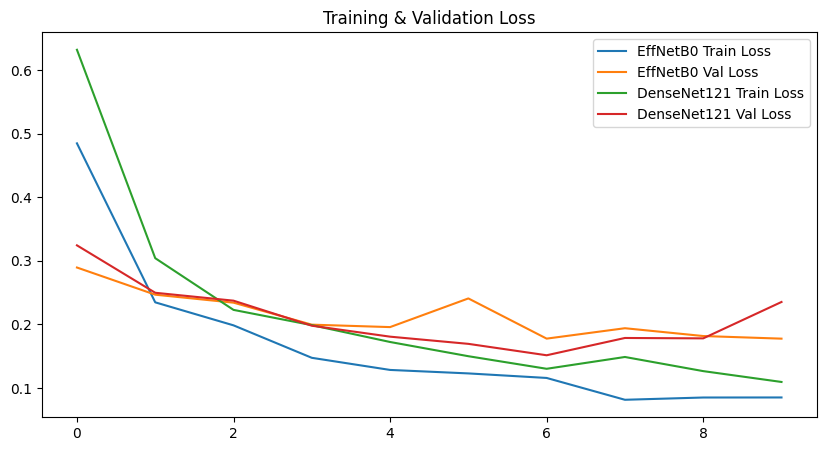

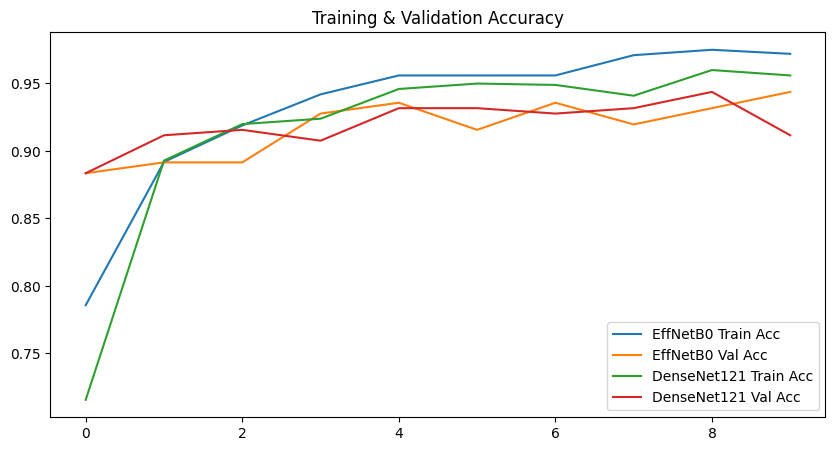

In [10]:
import matplotlib.pyplot as plt

# -------- Loss --------
plt.figure(figsize=(10,5))
plt.plot(history1.history['loss'], label='EffNetB0 Train Loss')
plt.plot(history1.history['val_loss'], label='EffNetB0 Val Loss')
plt.plot(history2.history['loss'], label='DenseNet121 Train Loss')
plt.plot(history2.history['val_loss'], label='DenseNet121 Val Loss')
plt.title("Training & Validation Loss")
plt.legend()
plt.show()

# -------- Accuracy --------
plt.figure(figsize=(10,5))
plt.plot(history1.history['accuracy'], label='EffNetB0 Train Acc')
plt.plot(history1.history['val_accuracy'], label='EffNetB0 Val Acc')
plt.plot(history2.history['accuracy'], label='DenseNet121 Train Acc')
plt.plot(history2.history['val_accuracy'], label='DenseNet121 Val Acc')
plt.title("Training & Validation Accuracy")
plt.legend()
plt.show()


In [21]:
import numpy as np
import pandas as pd
from tensorflow.keras.applications.efficientnet import preprocess_input

# Load gambar
img_path = '/content/drive/MyDrive/ACD/DATASET/testingdata/testing1.jpg'

img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)

# Preprocessing
img_array = preprocess_input(img_array)
img_array = np.expand_dims(img_array, axis=0)

# PREDIKSI YANG BENAR
prediction = ensemble_predict(img_array)[0]

# Prediksi kelas
predicted_class = class_names[np.argmax(prediction)]

# Tabel probabilitas
df = pd.DataFrame({
    "Class": class_names,
    "Probability (%)": np.round(prediction * 100, 2)
})

df = df.sort_values(by="Probability (%)", ascending=False).reset_index(drop=True)

print("Hasil Prediksi:")
print("---------------")
print(f"Prediksi Utama: {predicted_class}\n")
print(df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Hasil Prediksi:
---------------
Prediksi Utama: Aedes aegypti

                    Class  Probability (%)
0           Aedes aegypti        76.480003
1        Aedes albopictus        23.469999
2  Culex quinquefasciatus         0.050000


In [19]:
import numpy as np
import pandas as pd
from tensorflow.keras.applications.efficientnet import preprocess_input

# Load gambar
img_path = '/content/drive/MyDrive/ACD/DATASET/testingdata/testing2.jpg'

img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)

# Preprocessing
img_array = preprocess_input(img_array)
img_array = np.expand_dims(img_array, axis=0)

# PREDIKSI YANG BENAR
prediction = ensemble_predict(img_array)[0]

# Prediksi kelas
predicted_class = class_names[np.argmax(prediction)]

# Tabel probabilitas
df = pd.DataFrame({
    "Class": class_names,
    "Probability (%)": np.round(prediction * 100, 2)
})

df = df.sort_values(by="Probability (%)", ascending=False).reset_index(drop=True)

print("Hasil Prediksi:")
print("---------------")
print(f"Prediksi Utama: {predicted_class}\n")
print(df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Hasil Prediksi:
---------------
Prediksi Utama: Aedes albopictus

                    Class  Probability (%)
0        Aedes albopictus        50.400002
1           Aedes aegypti        49.590000
2  Culex quinquefasciatus         0.010000


In [20]:
import numpy as np
import pandas as pd
from tensorflow.keras.applications.efficientnet import preprocess_input

# Load gambar
img_path = '/content/drive/MyDrive/ACD/DATASET/testingdata/testing3.png'

img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)

# Preprocessing
img_array = preprocess_input(img_array)
img_array = np.expand_dims(img_array, axis=0)

# PREDIKSI YANG BENAR
prediction = ensemble_predict(img_array)[0]

# Prediksi kelas
predicted_class = class_names[np.argmax(prediction)]

# Tabel probabilitas
df = pd.DataFrame({
    "Class": class_names,
    "Probability (%)": np.round(prediction * 100, 2)
})

df = df.sort_values(by="Probability (%)", ascending=False).reset_index(drop=True)

print("Hasil Prediksi:")
print("---------------")
print(f"Prediksi Utama: {predicted_class}\n")
print(df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Hasil Prediksi:
---------------
Prediksi Utama: Culex quinquefasciatus

                    Class  Probability (%)
0  Culex quinquefasciatus        99.830002
1           Aedes aegypti         0.150000
2        Aedes albopictus         0.020000
